In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D

(602, 900, 3)

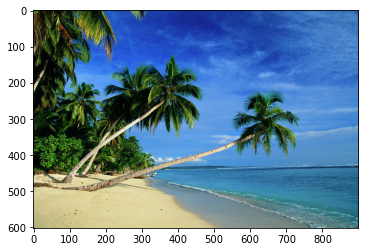

In [2]:
ogimage = skio.imread(fname="OriginalImage.jpg")
ogimage.shape
plt.imshow(ogimage)

(301, 450, 3)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


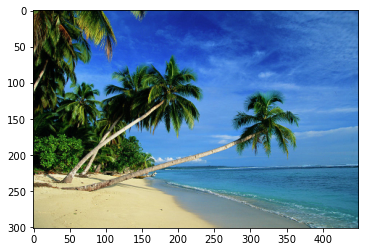

In [3]:
#reducing resolution of the image
ogimage_resized = resize(ogimage, (ogimage.shape[0] // 2, ogimage.shape[1] // 2),
                       anti_aliasing=False)
plt.imshow(ogimage_resized)
ogimage_resized.shape
skio.imsave(fname="ogimage_resized.jpg", arr=ogimage_resized)

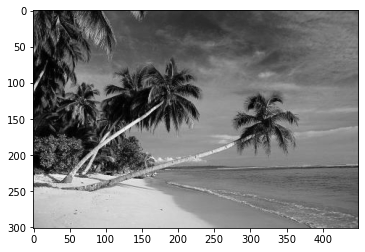

In [4]:
ogimage_resized = skio.imread(fname="ogimage_resized.jpg")
ogimage_grey = ogimage_resized[:,:,0]*0.21 + ogimage_resized[:,:,1]*0.72 + ogimage_resized[:,:,2]*0.07
plt.imshow(ogimage_grey,cmap=plt.cm.gray)

In [19]:
ogimage_resized.shape
trainingImage = ogimage_resized[:,0:225,:]
trainingImage.shape
testingImage = ogimage_resized[:,225:450,:]
testingImage.shape

(301, 450, 3)

(301, 225, 3)

(301, 225, 3)

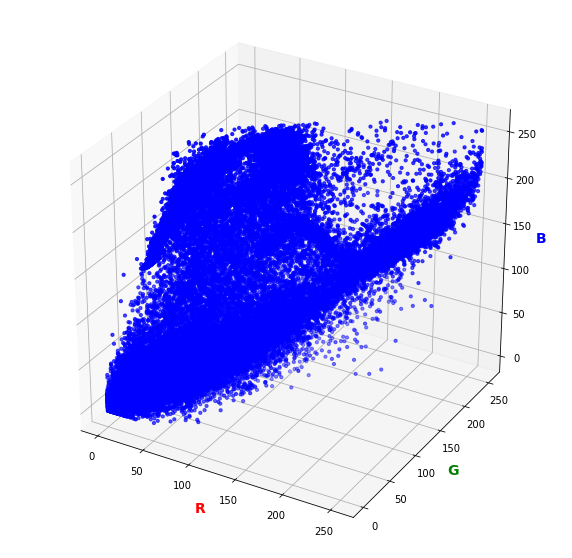

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.scatter(xs = trainingImage[:,:,0], ys = trainingImage[:,:,1], zs = trainingImage[:,:,2], s=10, c='b', depthshade=True)
x_label = ax.set_xlabel('R', fontsize=14, fontweight='bold', color='r')
y_label = ax.set_ylabel('G',fontsize=14, fontweight='bold', color='g')
z_label = ax.set_zlabel('B',fontsize=14, fontweight='bold', color='b')

In [37]:
def initializecenters(data,k):
    centers =  data[random.sample(range(0,data.shape[0]-1), 1)]
    while (centers.shape[0]<k):
        distvalue = np.array([min([dist(c,pixel) for c in centers]) for pixel in data])
        probs = distvalue/distvalue.sum()
        cusum = probs.cumsum()
        r = random.random()
        ind = np.where(cusum >= r)[0][0]
        centers = np.vstack((centers,data[ind]))
    centers = centers[centers[:,0].argsort()]
    return centers


def dist(a,b):
    distvalue = np.sqrt(2*((a[0] - b[0])**2) + 4*((a[1] - b[1])**2) + 3*((a[2] - b[2])**2))
    return np.round(distvalue)


def returndic(k):
    centerdic = {}    
    for c in range(k):
        centerdic.update({c : set()})
    return centerdic

def returncluster(data,k,centers):
    newcenterdic = returndic(k)
    for ind,pixel in enumerate(data):
        distvalues = list(map(lambda c:dist(c,pixel), centers))
        minindex = distvalues.index(min(distvalues))
        newcenterdic.get(minindex).add(ind)
    return newcenterdic
    
def is_converged(newcenters, oldcenters):
    return set([tuple(a) for a in newcenters]) == set([tuple(a) for a in oldcenters])

def computeloss(centers,centerdic,data):
    sqdisvalues =  list()
    for index,center in enumerate(centers):
        sqdisvalues.extend(list(map(lambda p:dist(p,center)**2, data[list(centerdic.get(index))])))
    return sum(sqdisvalues)/len(sqdisvalues)
    
    

In [38]:
R = np.reshape(trainingImage[:,:,0].flatten(),(trainingImage[:,:,0].flatten().shape[0],1))
Rnorm = (R - np.mean(R))/np.std(R)
G = np.reshape(trainingImage[:,:,1].flatten(),(trainingImage[:,:,1].flatten().shape[0],1))
Gnorm = (G - np.mean(G))/np.std(G)
B = np.reshape(trainingImage[:,:,2].flatten(),(trainingImage[:,:,2].flatten().shape[0],1))
Bnorm = (B - np.mean(B))/np.std(B)
RGB = np.column_stack((R, G, B))
RGBnorm = np.column_stack((Rnorm, Gnorm, Bnorm))
RGB.shape
RGBnorm.shape

(67725, 3)

(67725, 3)

In [50]:
N = RGBnorm.shape[0]
maxiter = 10
converged = False
i = 1
k = 5 
centers = initializecenters(RGBnorm,k)
previous_loss = 0
thres = 0.001
while(not converged):
    print(i)
    centerdic = returncluster(RGBnorm,k,centers)
    oldcenters = centers.copy()
    for c in range(k):
        centers[c] = (np.mean(RGBnorm[list(centerdic.get(c))], axis = 0))
    new_loss = computeloss(centers,centerdic,RGBnorm)
    if is_converged(centers,oldcenters):
        converged = True
    previous_loss = new_loss
    i += 1

        

1
2


In [51]:
centers[:,0] = (centers[:,0] * np.std(R)) + np.mean(R)
centers[:,1] = (centers[:,1] * np.std(G)) + np.mean(G)
centers[:,2] = (centers[:,2] * np.std(B)) + np.mean(B)
centers

array([[ 17.,  33.,  13.],
       [ 36.,  83., 189.],
       [ 81., 104.,  60.],
       [ 94., 151., 206.],
       [213., 203., 153.]])

In [52]:
centers =  np.rint(centers)
centers

array([[ 17.,  33.,  13.],
       [ 36.,  83., 189.],
       [ 81., 104.,  60.],
       [ 94., 151., 206.],
       [213., 203., 153.]])

In [53]:
clustersForTrainingData = returncluster(RGB,5,centers)
RGB[list(clustersForTrainingData.get(0))] = centers[0]
RGB[list(clustersForTrainingData.get(1))] = centers[1]
RGB[list(clustersForTrainingData.get(2))] = centers[2]
RGB[list(clustersForTrainingData.get(3))] = centers[3]
RGB[list(clustersForTrainingData.get(4))] = centers[4]

In [54]:
og = RGB.reshape((trainingImage.shape[0],trainingImage.shape[1],3))

In [55]:
og.shape

(301, 225, 3)

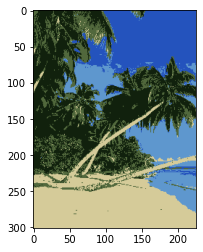

In [56]:
plt.imshow(og)

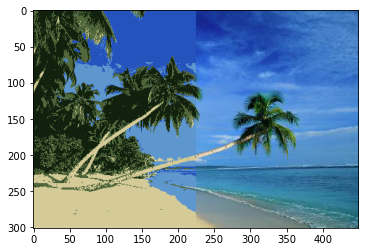

In [57]:
trainingImage = og
complete_image = np.column_stack((trainingImage,testingImage))
plt.imshow(complete_image)

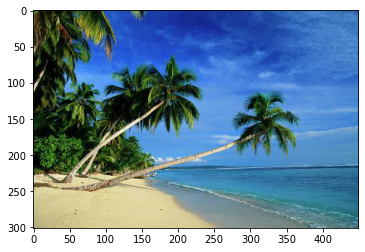

In [58]:
plt.imshow(ogimage_resized)

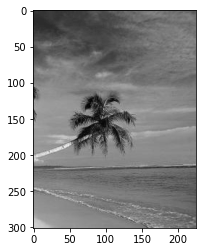

In [59]:
testingImage_gray = testingImage[:,:,0]*0.21 + testingImage[:,:,1]*0.72 + testingImage[:,:,2]*0.07
plt.imshow(testingImage_gray,cmap=plt.cm.gray)